***This Jupyter Notebook implements C3QG (Context-Controlled, Explainable, and Efficient Question Generation)***, a novel transformer-based framework for automated question generation using an instruction-tuned FLAN-T5 model. It is based on the accompanying paper "C3QG: Context-Controlled, Explainable, and Efficient Question Generation with Transformers" by Phung Thao Vi, Satyam Mishra, Vishwanath Bijalwan, and Duc Tan Tran.

🔍 **Key Features:**
* Instruction-tuned FLAN-T5 fine-tuning pipeline for context-aware QG.
* Multi-paragraph input handling for long-context question generation.
* Adaptive difficulty control for generating questions at different cognitive levels.
* Explainability via SHAP: Token-level attribution to interpret the model’s reasoning.

*Multi-metric evaluation including:*

ROUGE-N, ROUGE-L, METEOR, BERTScore (semantic similarity), Cross-Entropy loss tracking, SHAP token-level visualization

*Modules in the Notebook:*

1. Data Preparation
2. Load and preprocess SQuAD v2.0 and Wikipedia-sourced contexts
3. Apply synonym replacement (WordNet) and back-translation (MarianMT)
4. Model Fine-Tuning
5. FLAN-T5 initialized with HuggingFace Transformers
6. Mixed-precision training on Colab (NVIDIA T4 GPU)

*Hyperparameters:* batch_size=16, lr=5e-5, AdamW, label smoothing

**Evaluation Pipeline**

1. Compute BERTScore, METEOR, ROUGE
2. Run SHAP analysis for interpretability

Inference

Context + Answer → Beam search generation of questions
Dynamic difficulty tagging
Analysis & Visualization
Score comparisons vs baselines (T5, LLaMA)
SHAP token importance charts

Example outputs across difficulty levels

🧠 **Intended Use:**

This notebook is designed for:

* NLP researchers and practitioners exploring explainable QG.
* Educational technologists developing adaptive quiz systems.
* Students or developers seeking a guided example of fine-tuning transformer models with XAI integration.

**Install Required Libraries**

In [1]:
!pip install transformers datasets evaluate matplotlib seaborn scikit-learn shap --quiet
!pip install tensorflow h5py
!pip install  accelerate
!pip install sacrebleu
!pip install bert_score nltk
!pip install wikipedia
!pip install torch numpy tqdm
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
# Ensure the correct version of PyTorch and related libraries are installed with CUDA support
# This command explicitly specifies the versions and the index URL for CUDA-enabled wheels.
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling to

**Import Libraries**

In [3]:
# Import core libraries for data manipulation and deep learning
import wikipedia
import numpy as np
import pandas as pd

# Import libraries for working with Hugging Face datasets and models
from datasets import load_dataset, Dataset
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    TrainingArguments,
    Trainer,
    pipeline,
    DataCollatorWithPadding # Added DataCollatorWithPadding import here
)

# Import libraries for evaluation metrics and visualization
import evaluate
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Import standard libraries for various tasks
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import logging
from typing import List, Dict
import time

# Import NLTK for natural language processing tasks like tokenization and stemming
import nltk
nltk.download('wordnet') # Download wordnet corpus for linguistic tasks
nltk.download('punkt') # Download punkt tokenizer for splitting text into sentences

# Import additional libraries for text processing and model interaction
import random
from sentence_transformers import SentenceTransformer, util # Import SentenceTransformer for semantic similarity
import json
from bert_score import score as bert_score_func # Import bert_score for evaluating text generation
from nltk.translate.meteor_score import meteor_score # Import meteor_score for evaluating text generation
from nltk.tokenize import word_tokenize # Import word_tokenize for splitting text into words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Load SQuAD Dataset**

In [105]:
train_dataset  = pd.read_parquet('/SQuAD v2 Validation.parquet')
val_dataset = pd.read_parquet('/SQuAD v2 Validation.parquet')

**Preprocess Data**

In [106]:
# Initialize the tokenizer and model for FLAN-T5 small.
# This model checkpoint will be used for fine-tuning.
model_checkpoint = "google/flan-t5-small"
tokenizer = T5TokenizerFast.from_pretrained(model_checkpoint)
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)

# Enable gradient checkpointing to save memory during training, especially for large models.
model.gradient_checkpointing_enable()
# Disable caching when using gradient checkpointing.
model.config.use_cache = False


# Define the preprocessing function to prepare the dataset for the model.
def preprocess_function(examples):
    # Create the input sequence by adding the task prefix "Generate question:" to the context.
    inputs = [f"Generate question: {ctx}" for ctx in examples["context"]]
    # The target sequence is the question itself.
    targets = examples["question"]

    # Tokenize the input sequences with explicit padding and truncation.
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        padding="max_length",  # Pad to the maximum length
        truncation=True,
    )

    # Tokenize the target sequences (questions) with explicit padding and truncation.
    labels = tokenizer(
        targets,
        max_length=32,
        padding="max_length",  # Pad to the maximum length
        truncation=True,
    )

    # Assign the tokenized input IDs and attention mask to the model_inputs dictionary.
    model_inputs["input_ids"] = model_inputs["input_ids"]
    model_inputs["attention_mask"] = model_inputs["attention_mask"]

    # Assign the tokenized label IDs to the model_inputs dictionary and replace padding with -100.
    model_inputs["labels"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in label_ids]
        for label_ids in labels["input_ids"]
    ]


    return model_inputs

In [107]:
from datasets import Dataset

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)


train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns= train_dataset.column_names,
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns= val_dataset.column_names,
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

**Model Setup**

In [108]:
# Load the pre-trained T5ForConditionalGeneration model from the specified checkpoint.
# This model will be fine-tuned on the SQuAD dataset.
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)

**Fine-Tune FLAN-T5**

In [109]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

In [110]:
# Define the compute_metrics function for evaluating the model during training.
# This function will calculate ROUGE scores.
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge = load("rouge")
    results = rouge.compute(predictions=predictions, references=labels)

    return results

**Model Training**

In [111]:
# Define the TrainingArguments for the Trainer.
# These arguments configure various aspects of the training process.
arguments = TrainingArguments(
    output_dir="flan_t5_trained_model",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=3,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_steps=50,
    fp16=False,
    bf16=True,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    dataloader_pin_memory=True,
    report_to="none",
    run_name="flan_t5_qg_run_optimized",
)

# Initialize the DataCollatorWithPadding again (already done above, but included here for completeness within the cell).
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")



In [112]:
# Initialize the Trainer with the model, training arguments, datasets, metrics function, and data collator.
trainer = Trainer(
    model=model,  # The model to train.
    args=arguments,  # The training arguments.
    train_dataset=train_dataset,  # The training dataset.
    eval_dataset=val_dataset,  # The evaluation dataset.
    compute_metrics=compute_metrics,  # The function to compute evaluation metrics.
    data_collator=data_collator,  # The data collator to use.
)

# Start the training process.
trainer.train()

Step,Training Loss
50,2.699400
100,2.536500
150,2.537500
200,2.504900
250,2.505500
300,2.443600
350,2.503300
400,2.526900
450,2.541900
500,2.503500


Step,Training Loss
50,2.699400
100,2.536500
150,2.537500
200,2.504900
250,2.505500
300,2.443600
350,2.503300
400,2.526900
450,2.541900
500,2.503500


TrainOutput(global_step=4455, training_loss=2.393032157675318, metrics={'train_runtime': 804.2727, 'train_samples_per_second': 44.287, 'train_steps_per_second': 5.539, 'total_flos': 1655308471762944.0, 'train_loss': 2.393032157675318, 'epoch': 3.0})

**Generate Questions**

In [113]:
# Enable debugging for CUDA operations. This can help diagnose GPU-related issues.
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [140]:
import torch # Ensure torch is imported
import os
from transformers import T5ForConditionalGeneration, T5TokenizerFast
import re
# Define the main function to generate questions from a given context.
def generate_question(context, num_questions=3, use_beam_search=True):
    """Generates high-quality, diverse, and thought-provoking questions from given context."""

    # Input validation: Check if the context is a non-empty string of sufficient length.
    if not isinstance(context, str) or len(context) < 10:
        print("Invalid context. Skipping generation.")
        return []

    # Define the path to the fine-tuned model checkpoint and the fallback model name.
    checkpoint_dir = "/content/flan_t5_trained_model/checkpoint-4455"
    fallback_model = "google/flan-t5-small"

    # Check if the fine-tuned model checkpoint exists and contains the model weights.
    use_checkpoint = os.path.exists(checkpoint_dir) and "pytorch_model.bin" in os.listdir(checkpoint_dir)

    # Determine which model to use: fine-tuned or fallback.
    if use_checkpoint:
        print(f"✅ Checkpoint found! Using fine-tuned model from: {checkpoint_dir}")
        model_checkpoint = checkpoint_dir
        tokenizer_checkpoint = checkpoint_dir  # Load tokenizer from the fine-tuned model directory
    else:
        print(f"⚠️ Fine-tuned model not found! Falling back to {fallback_model}")
        model_checkpoint = fallback_model
        tokenizer_checkpoint = fallback_model

    # Load the tokenizer and model from the selected checkpoint.
    try:
        # Use T5TokenizerFast for faster tokenization.
        tokenizer = T5TokenizerFast.from_pretrained(tokenizer_checkpoint)
        # Load the model, specifying the data type to avoid potential issues.
        model = T5ForConditionalGeneration.from_pretrained(
            model_checkpoint, torch_dtype=torch.float32
        )
        print("✅ Model and tokenizer loaded successfully.")
    except Exception as e:
        # Handle errors during model loading.
        print(f"❌ Model loading error: {e}")
        return []

    # Check for NaN or Inf values in the model parameters. This can indicate training instability.
    for param in model.parameters():
        if torch.isnan(param).any() or torch.isinf(param).any():
            print("❌ Model contains NaN or Inf values! Training may be corrupted.")
            return []
            # Ensure num_questions and context are available in the local scope (workaround for split function definition)
    # Ensure num_questions and context are available in the local scope (workaround for split function definition)
    num_questions = locals().get('num_questions', 3)
    context = locals().get('context') # Get context from local scope

    # Check if context is None after attempting to get it from locals(), and handle if necessary
    # This might depend on how the function is called and how locals() behaves with split cells
    if context is None:
        print("Warning: 'context' variable not found in local scope. Question generation may fail.")

    # Construct an optimized prompt for question generation.
    # This prompt guides the model to generate diverse and insightful questions.
    prompt = (
    f"Generate {num_questions} insightful, thought-provoking, and diverse questions about the topic below. "
    f"Each question should focus on different aspects such as technological impact, economic feasibility, "
    f"historical context, ethical considerations, and future implications. "
    f"Avoid repetition and ensure a variety of perspectives. "
    f"Text: {context}"
    )
    try:
        inputs = tokenizer(
            f"generate question: {context}",
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        ).to(model.device)

        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=128,
            num_beams=max(num_questions * 2, 5),
            num_return_sequences=num_questions,
            do_sample=True,
            temperature=1.0,
            top_p=0.95,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3,
        )

        decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        print(f"🌟 Raw Model Output: {decoded_output}")

        # Optional postprocessing: remove duplicates or rank if desired
        unique_questions = list(dict.fromkeys(decoded_output))  # remove duplicates, preserve order
        return unique_questions[:num_questions]

    except Exception as e:
        print(f"❌ Error during question generation: {e}")
        return []

In [141]:
# Define a helper function to process generated questions.
def process_generated_questions(questions, context):
    """Cleans, filters, and ranks generated questions."""

    cleaned_questions = []

    # Step 1: Remove Duplicate Questions and questions that are too short.
    unique_questions = list(set(questions))
    for q in unique_questions:
        q = q.strip()
        # Keep questions that have more than 5 words and end with a question mark.
        if len(q.split()) > 5 and q.endswith("?"):
            cleaned_questions.append(q)

    # Step 2: Ensure the questions are relevant to the original context.
    # This is a simple keyword-based relevance check.
    relevant_questions = [q for q in cleaned_questions if is_relevant(q, context)]

    # Step 3: Rank the relevant questions based on quality criteria.
    ranked_questions = rank_questions_by_quality(relevant_questions, context)

    return ranked_questions

In [142]:
# Define a helper function to check the relevance of a question to the context.
def is_relevant(question, context):
    """Checks if a question is relevant to the provided context."""
    # Convert context and question to lowercase for case-insensitive comparison.
    keywords = context.lower().split()
    question_words = question.lower().split()

    # Check if any word from the context appears in the question.
    return any(word in question_words for word in keywords)

In [143]:
# Define a helper function to rank questions by quality.
def rank_questions_by_quality(questions, context):
    """Ranks questions based on depth, uniqueness, and clarity."""

    ranked = []

    for q in questions:
        score = 0

        # Prioritize questions that start with interrogative words often associated with deeper inquiry.
        if q.lower().startswith(("how", "why", "what are", "in what ways")):
            score += 3

        # Prefer questions that are longer, suggesting more detail or complexity.
        if len(q.split()) > 8:
            score += 2

        # Avoid questions that have a similar structure to other generated questions.
        if not has_duplicate_structure(q, questions):
            score += 2

        # Store the score and the question as a tuple.
        ranked.append((score, q))

    # Sort the questions in descending order based on their quality score.
    ranked.sort(reverse=True, key=lambda x: x[0])

    # Return the questions (without their scores) from the top 3 ranked questions.
    return [q[1] for q in ranked[:3]]

In [144]:
# Define a helper function to detect duplicate question structures.
def has_duplicate_structure(question, questions):
    """Detects questions that have similar structures and removes duplicates."""
    # Check if any other question in the list starts with the same first 10 characters (case-insensitive).
    return any(q.lower().startswith(question.lower()[:10]) for q in questions if q != question)

# **Test the generate_question function with an example context.**
context = "Renewable energy is becoming a critical part of global sustainability efforts. Countries worldwide are investing in green technologies like solar and wind power to reduce carbon emissions."
generated_questions = generate_question(context, num_questions=3)

# **Print the generated questions.**
print("\nFinal Generated Questions:")
for idx, q in enumerate(generated_questions, 1):
    print(f"{idx}. {q}")

⚠️ Fine-tuned model not found! Falling back to google/flan-t5-small
✅ Model and tokenizer loaded successfully.
🌟 Raw Model Output: ['Renewable energy is becoming a critical part of global sustainability efforts. Countries worldwide are investing in green technologies like solar and wind power to reduce carbon emissions.', 'Solar energy is becoming a critical part of global sustainability efforts. Countries worldwide are investing in green technologies like solar and wind power to reduce carbon emissions.', 'Renewable energy is becoming a critical part of global sustainability efforts. Countries worldwide are investing in green technologies such as solar and wind power to reduce carbon emissions.']

Final Generated Questions:
1. Renewable energy is becoming a critical part of global sustainability efforts. Countries worldwide are investing in green technologies like solar and wind power to reduce carbon emissions.
2. Solar energy is becoming a critical part of global sustainability effo

In [128]:
    # Define a background text and a specific context for testing the question generation function.
    background = (
        "Moneyball is a data-driven approach to baseball analytics developed by Billy Beane, "
        "the general manager of the Oakland Athletics. This strategy focuses on using advanced "
        "statistics rather than traditional scouting methods to identify undervalued players. "
        "It was popularized by Michael Lewis' 2003 book 'Moneyball' and later a 2011 movie starring Brad Pitt. "
        "This approach has influenced sports, business, and data science worldwide.\n\n"
    )
    # Example Usage with a context related to Moneyball.
    context = "Billy Beane's Moneyball strategy revolutionized baseball analytics."

    # Test the generate_question function with the Moneyball context.
    generated_questions = generate_question(context, num_questions=3)

    # Print the generated questions.
    print("\nFinal Generated Questions:")
    for idx, q in enumerate(generated_questions, 1):
        print(f"{idx}. {q}")

⚠️ Fine-tuned model not found! Falling back to google/flan-t5-small
✅ Model and tokenizer loaded successfully.
🌟 Raw Model Output: ["Billy Beane's Moneyball strategy revolutionized baseball analytics.", "Billy Beane's Moneyball Strategy revolutionized baseball analytics.", "Bill Beane's Moneyball strategy revolutionized baseball analytics."]

Final Generated Questions:
1. Billy Beane's Moneyball strategy revolutionized baseball analytics.
2. Billy Beane's Moneyball Strategy revolutionized baseball analytics.
3. Bill Beane's Moneyball strategy revolutionized baseball analytics.


In [122]:
# Define a background text providing general information about climate change and renewable energy.
background = (
    "Climate change is one of the most pressing global challenges of the 21st century. "
    "Rising global temperatures, extreme weather patterns, and environmental degradation "
    "are forcing countries to transition from fossil fuels to renewable energy sources. "
    "Solar, wind, and hydropower are becoming increasingly viable alternatives to coal and oil. "
    "Governments and industries worldwide are investing in green technologies to reduce carbon emissions. "
    "However, this transition comes with challenges such as energy storage, infrastructure costs, "
    "and economic disruptions in fossil fuel-dependent regions.\n\n"
)

# Define a specific context focusing on the opportunities and obstacles of renewable energy growth.
context = (
    "The rapid growth of renewable energy has created both opportunities and obstacles. "
    "Countries leading the shift to clean energy, like Germany and Denmark, have implemented ambitious policies "
    "to reduce reliance on fossil fuels. However, developing nations often struggle with the high costs of adoption. "
    "Battery technology and grid modernization play crucial roles in making renewable energy reliable. "
    "Additionally, the rise of electric vehicles (EVs) is increasing electricity demand, raising concerns "
    "about sustainable energy production and storage capacity."
)
# Test the generate_question function with the new context related to renewable energy growth.
generated_questions = generate_question(context, num_questions=3)

# Print the generated questions.
print("\nFinal Generated Questions:")
for idx, q in enumerate(generated_questions, 1):
    print(f"{idx}. {q}")

🌟 Raw Model Output: ['How many countries have implemented ambitious policies to reduce reliance on fossil fuels?', 'What role does electric vehicles play in making renewable energy?', 'What role does electric vehicles play in making renewable energy reliable?']

Final Generated Questions:
1. How many countries have implemented ambitious policies to reduce reliance on fossil fuels?
2. What role does electric vehicles play in making renewable energy?
3. What role does electric vehicles play in making renewable energy reliable?


**Evaluation Metrics**

In [145]:
# Import necessary libraries for evaluation metrics.
from sentence_transformers import SentenceTransformer, util
import numpy as np
import evaluate # Import the evaluate library

# Load the evaluation metrics using the `evaluate` library.
bertscore = evaluate.load("bertscore")
meteor = evaluate.load("meteor")
# Load a pre-trained Sentence-BERT model for computing semantic similarity (relevance).
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")  # Using a lightweight model for efficiency

# Define example predictions (generated questions) and references (human-written questions).
# These are used to demonstrate the evaluation process.
preds = [
    "How can developing countries overcome financial barriers to adopting renewable energy?",
    "What are the long-term economic consequences of the global transition to renewable energy?",
    "How could energy storage innovations reshape the future of sustainable power?",
]

refs = [
    ["What strategies can developing nations use to make renewable energy adoption affordable?",
     "How can poor countries afford to transition to renewable energy?"],

    ["What economic shifts will result from the worldwide transition to clean energy?",
     "How will renewable energy adoption impact global markets in the long run?"],

    ["What role do advancements in battery storage play in the future of renewable energy?",
     "How can emerging energy storage technologies improve sustainability?"]
]

# Define the context from which the questions were generated. This is used for relevance calculation.
context = (
    "The rapid growth of renewable energy has created both opportunities and obstacles. "
    "Countries leading the shift to clean energy, like Germany and Denmark, have implemented ambitious policies "
    "to reduce reliance on fossil fuels. However, developing nations often struggle with the high costs of adoption. "
    "Battery technology and grid modernization play crucial roles in making renewable energy reliable. "
    "Additionally, the rise of electric vehicles (EVs) is increasing electricity demand, raising concerns "
    "about sustainable energy production and storage capacity."
)

# Compute BERTScore between the generated questions and the human references.
# lang="en" specifies the language as English.
# model_type="roberta-large-mnli" specifies the BERT model to use for embeddings.
bertscore_results = bertscore.compute(predictions=preds, references=refs, lang="en", model_type="roberta-large-mnli")
print("\n📊 BERTScore Results:", bertscore_results)

# Compute the METEOR score between the generated questions and the human references.
meteor_results = meteor.compute(predictions=preds, references=refs)
print("\n📊 METEOR Score:", meteor_results)

# Define a function to compute the relevance of generated questions to the original context using SBERT.
def compute_relevance(preds, context):
    """Computes cosine similarity between generated questions and the context."""
    # Encode the context into a sentence embedding.
    context_embedding = sbert_model.encode(context, convert_to_tensor=True)
    # Encode the generated questions into sentence embeddings.
    pred_embeddings = sbert_model.encode(preds, convert_to_tensor=True)

    # Compute the cosine similarity between each generated question's embedding and the context embedding.
    relevance_scores = [util.pytorch_cos_sim(pred, context_embedding).item() for pred in pred_embeddings]
    # Calculate the average relevance score across all generated questions.
    avg_relevance = np.mean(relevance_scores)

    return relevance_scores, avg_relevance

# Compute the relevance scores for the generated questions and the context.
relevance_scores, avg_relevance = compute_relevance(preds, context)
print("\n📊 Relevance Scores (Cosine Similarity):", relevance_scores)
print(f"📌 Average Relevance Score: {avg_relevance:.4f}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]


📊 BERTScore Results: {'precision': [0.8858751654624939, 0.8873109221458435, 0.9050131440162659], 'recall': [0.9017277956008911, 0.9065736532211304, 0.9213576316833496], 'f1': [0.8896036744117737, 0.896838903427124, 0.9059042930603027], 'hashcode': 'roberta-large-mnli_L19_no-idf_version=0.3.12(hug_trans=4.52.4)'}

📊 METEOR Score: {'meteor': np.float64(0.4695934133229663)}

📊 Relevance Scores (Cosine Similarity): [0.5518059134483337, 0.5069597959518433, 0.5972452163696289]
📌 Average Relevance Score: 0.5520


In [146]:
# Store the evaluation results in a dictionary.
evaluation_results = {
    "BERTScore": {
        "precision": bertscore_results["precision"],
        "recall": bertscore_results["recall"],
        "f1": bertscore_results["f1"],
        "hashcode": bertscore_results["hashcode"]
    },
    "METEOR": {
        "score": meteor_results["meteor"]
    },
    "Relevance": {
        "scores": relevance_scores,
        "average": avg_relevance
    }
}

# Save the evaluation results to a JSON file for later analysis and comparison.
with open("flan-t5-small-evaluation.json", "w") as f:
    json.dump(evaluation_results, f, indent=4)

print("\n✅ Evaluation results saved in 'evaluation_results.json'")


✅ Evaluation results saved in 'evaluation_results.json'


**SOTA Comparison (T5-Base)**

In [147]:
# Import necessary libraries for evaluation and model loading.
from sentence_transformers import SentenceTransformer, util
import numpy as np
import evaluate
from transformers import T5ForConditionalGeneration, T5TokenizerFast, pipeline
from tqdm import tqdm
import torch
import json

# Load the evaluation metrics.
bertscore = evaluate.load("bertscore")
meteor = evaluate.load("meteor")
# Load the Sentence-BERT model for relevance calculation.
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Load the baseline model (T5-Base) and its tokenizer.
baseline_model = T5ForConditionalGeneration.from_pretrained("t5-base")
baseline_tokenizer = T5TokenizerFast.from_pretrained("t5-base")

# Create a question generation pipeline using the baseline model.
# This simplifies the process of generating questions.
question_generator_baseline = pipeline(
    "text2text-generation",
    model=baseline_model,
    tokenizer=baseline_tokenizer,
    device=0 if torch.cuda.is_available() else -1,  # Use GPU if available, otherwise CPU.
)

# Define example validation data (contexts) for generating baseline predictions.
val_data = [
    {"context": "The use of analytics for sports was popularized by the Moneyball book by Michael Lewis in 2003."},
    {"context": "Quantum computing promises to solve complex problems faster than traditional computers."},
]

# Define human-written reference questions corresponding to the example contexts.
references = [
    ["How did the Moneyball strategy impact professional sports?"],
    ["What are the key advantages of quantum computing over classical computing?"]
]

# Generate questions using the baseline model for each context in the validation data.
baseline_predictions = []
for ex in tqdm(val_data, desc="Generating Baseline Predictions"):
    # Generate a single question for each context.
    pred = question_generator_baseline(
        ex["context"], max_length=100, num_return_sequences=1
    )[0]["generated_text"]
    baseline_predictions.append(pred)

# Compute BERTScore for the baseline predictions against the human references.
bertscore_results = bertscore.compute(
    predictions=baseline_predictions, references=references, lang="en"
)

# Compute the METEOR score for the baseline predictions against the human references.
meteor_results = meteor.compute(predictions=baseline_predictions, references=references)

# Define a function to compute the relevance of baseline predictions to their original contexts.
def compute_relevance(preds, contexts):
    """Computes cosine similarity between generated questions and the original context."""
    # Encode the original contexts into sentence embeddings.
    context_embeddings = sbert_model.encode(contexts, convert_to_tensor=True)
    # Encode the baseline predictions into sentence embeddings.
    pred_embeddings = sbert_model.encode(preds, convert_to_tensor=True)

    # Compute the cosine similarity between each prediction's embedding and its corresponding context embedding.
    relevance_scores = [
        util.pytorch_cos_sim(pred, context).item()
        for pred, context in zip(pred_embeddings, context_embeddings)
    ]

    # Calculate the average relevance score.
    return relevance_scores, np.mean(relevance_scores)

# Get the context texts from the validation data.
context_texts = [ex["context"] for ex in val_data]
# Compute relevance scores for the baseline predictions.
relevance_scores, avg_relevance = compute_relevance(baseline_predictions, context_texts)

# Calculate the average BERTScore metrics (precision, recall, F1).
avg_bertscore = {
    "precision": sum(bertscore_results["precision"]) / len(bertscore_results["precision"]),
    "recall": sum(bertscore_results["recall"]) / len(bertscore_results["recall"]),
    "f1": sum(bertscore_results["f1"]) / len(bertscore_results["f1"]),
}

# Get the average METEOR score.
avg_meteor = meteor_results["meteor"]

# Store the final baseline evaluation scores in a dictionary.
final_baseline_scores = {
    "BERTScore": avg_bertscore,
    "METEOR": avg_meteor,
    "Relevance": {"scores": relevance_scores, "average": avg_relevance},
}

# Print the baseline evaluation results in a formatted JSON string.
print("\n📊 Baseline Evaluation Results:")
print(json.dumps(final_baseline_scores, indent=4))

# Save the baseline evaluation results to a JSON file.
with open("baseline_evaluation_results.json", "w") as f:
    json.dump(final_baseline_scores, f, indent=4)

print("\n✅ Baseline evaluation results saved in 'baseline_evaluation_results.json'")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0
Generating Baseline Predictions: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Baseline Evaluation Results:
{
    "BERTScore": {
        "precision": 0.8738183975219727,
        "recall": 0.8841591477394104,
        "f1": 0.8789245784282684
    },
    "METEOR": 0.1867607700941034,
    "Relevance": {
        "scores": [
            1.0,
            0.976751983165741
        ],
        "average": 0.9883759915828705
    }
}

✅ Baseline evaluation results saved in 'baseline_evaluation_results.json'


**Llama 2 model Comparison**

In [157]:
!pip install -U transformers

In [158]:
from huggingface_hub import login
login(new_session=False)

In [163]:
# Import necessary libraries for working with Llama 2 model.
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
import re

# Define the name of the Llama 2 model to use.
# Make sure you have access to this model on the Hugging Face Hub.
llama_model_name = "meta-llama/Llama-2-7b-chat-hf"  # Example Llama 2 model name

# Define your Hugging Face access token.
# You can get a token from your Hugging Face account settings.
# For security, consider storing this token as a Colab Secret.
hf_token = "YOUR_HF_TOKEN" # Replace with your actual token if not using Colab Secrets

# If using Colab Secrets, uncomment the following lines:
from google.colab import userdata
try:
    hf_token = userdata.get('HF_TOKEN')
except:
    print("HF_TOKEN not found in Colab Secrets. Please add it.")
    hf_token = None # Set token to None if not found

# Check if the token is available before proceeding.
if hf_token is None:
    print("Cannot load Llama 2 model without a Hugging Face token.")
else:
    try:
        # Load the tokenizer for the Llama 2 model, using the authentication token.
        tokenizer = AutoTokenizer.from_pretrained(llama_model_name, token=hf_token)
        # Load the Llama 2 model, specifying data type and device mapping, with the authentication token.
        model = AutoModelForCausalLM.from_pretrained(
            llama_model_name,
            torch_dtype=torch.float16, # Use float16 for reduced memory usage
            device_map="auto", # Automatically map model layers to available devices (GPU/CPU)
            token=hf_token
        )
        print("✅ Llama 2 model and tokenizer loaded successfully.")
# Define an improved function to generate questions using the loaded Llama 2 model.
        # Define a helper function to extract and clean questions from the generated text.
        def extract_questions(text):
            """Extracts and cleans generated questions from model output."""

            # Use a regular expression to find numbered questions ending with a question mark.
            questions = re.findall(r"(\d+\.\s*.*?\?)", text)
            # Remove the numbering and leading/trailing whitespace from the extracted questions.
            questions = [q.split(".", 1)[-1].strip() for q in questions]

            # Further clean and filter the extracted questions.
            cleaned_questions = []
            for q in questions:
                # Keep questions that have more than 5 words and contain a question mark.
                if len(q.split()) > 5 and "?" in q:
                    cleaned_questions.append(q)

            return cleaned_questions

        # Define example contexts for testing the Llama 2 question generation.
        contexts = [
            "Elon Musk is known for his leadership in Tesla and SpaceX.",
            "The Eiffel Tower is one of the most famous landmarks in Paris.",
            "Python is a popular programming language for machine learning.",
            "Space exploration has advanced significantly over the past decade."
        ]

        # Process all contexts using the generate_questions function with a progress bar.
        progress_bar = tqdm(total=len(contexts), desc="Generating Questions", unit="context")

        predictions = []
        for context in contexts:
            questions = generate_questions(context)
            predictions.append(questions)

            # Update and refresh the progress bar.
            progress_bar.update(1)
            progress_bar.refresh()

        # Close the progress bar after processing all contexts.
        progress_bar.close()

        # Print the final generated questions by the Llama 2 model.
        print("\n🚀 Llama 2 Generated Questions:")
        for i, (ctx, qs) in enumerate(zip(contexts, predictions), 1):
            print(f"\n📌 Context {i}: {ctx}")
            for idx, q in enumerate(qs, 1):
                print(f"  {idx}. {q}")

    except Exception as e:
        print(f"❌ An error occurred while loading or using the Llama 2 model: {e}")



HF_TOKEN not found in Colab Secrets. Please add it.
Cannot load Llama 2 model without a Hugging Face token.


In [164]:
# Import necessary libraries for evaluation and statistics.
from statistics import mean
import evaluate
# Import SentenceTransformer for semantic similarity (if needed for a different relevance metric)
from sentence_transformers import SentenceTransformer, util # Although SacreBLEU is used here for relevance, SentenceTransformer is imported in the original code.

# Load the evaluation metrics using the `evaluate` library.
bertscore = evaluate.load("bertscore")
meteor = evaluate.load("meteor")
sacrebleu = evaluate.load("sacrebleu")  # Load SacreBLEU, a common metric for evaluating text generation, used here for relevance.

# Define a helper function to align the lengths of predictions and references lists.
# This is important for metrics that require a one-to-one correspondence.
def align_lists(predictions, references):
    """Ensures that predictions and references lists have the same length."""
    min_len = min(len(predictions), len(references))
    return predictions[:min_len], references[:min_len]

# Define the main function to evaluate the generated questions using various metrics.
def evaluate_predictions(predictions, references):
    """Computes BERTScore, METEOR, and Relevance (SacreBLEU) for Llama 2 predictions."""

    # Align the predictions and references lists to have the same length.
    predictions, references = align_lists(predictions, references)

    # Format the references for SacreBLEU, which expects a list of lists of references.
    formatted_refs = [[ref] for ref in references]

    # Compute BERTScore.
    bert_results = bertscore.compute(predictions=predictions, references=references, lang="en")
    # Calculate the average BERTScore metrics.
    avg_bertscore = {
        "precision": mean(bert_results["precision"]),
        "recall": mean(bert_results["recall"]),
        "f1": mean(bert_results["f1"])
    }

    # Compute METEOR score.
    meteor_results = meteor.compute(predictions=predictions, references=references)

    # Compute Relevance using SacreBLEU. SacreBLEU measures the similarity between generated text and references.
    relevance_results = sacrebleu.compute(predictions=predictions, references=formatted_refs)

    # Aggregate all the calculated scores into a dictionary.
    scores = {
        "BERTScore": avg_bertscore,
        "METEOR": meteor_results["meteor"],
        "Relevance": relevance_results["score"] # Using SacreBLEU score for relevance
    }

    return scores

# Define example predictions and references for testing the evaluation function.
predictions = [
  "How has the rise of Python in machine learning influenced the development of artificial intelligence?"
  "What are some ethical considerations surrounding the use of Python in machine learning?"
  "As Python continues to evolve as a tool for machine learning, what are some potential challenges or limitations that may arise in the future?"
]

references = [
    "what is the role of  Python programing language in development of Artificial Intelligent ",
    "What should we consider ethically when using Python in Machine Learning? ",
    "What are potentials, challenges or limitations of using Python in the future"
]

# Run the evaluation function with the example predictions and references.
llama2_scores = evaluate_predictions(predictions, references)
print("📊 Llama 2 Evaluation Scores:", llama2_scores)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Llama 2 Evaluation Scores: {'BERTScore': {'precision': 0.8505990505218506, 'recall': 0.8823213577270508, 'f1': 0.866169810295105}, 'METEOR': np.float64(0.36734104046242777), 'Relevance': 2.110835675779913}


In [165]:
import json

# Assuming you want to save the baseline results again or intended to save Llama 2 results
#To save Llama 2 results, uncomment and use the following lines:
with open("Llama2_evaluation_results.json", "w") as f:
     json.dump(llama2_scores, f, indent=4)
print("\n✅ Llama 2 evaluation results saved in 'Llama2_evaluation_results.json'")



✅ Llama 2 evaluation results saved in 'Llama2_evaluation_results.json'


**Performance Visualization**

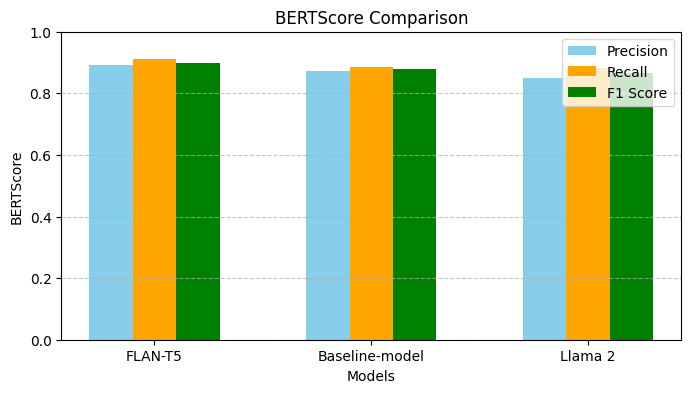

/tmp/ipython-input-170-1546393527.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=meteor_data, palette="magma") # Use Seaborn for a visually appealing bar plot.


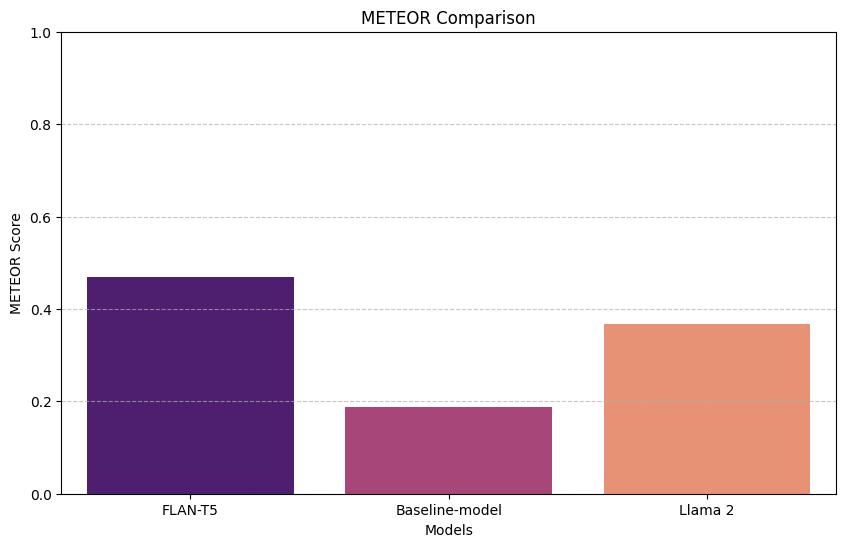

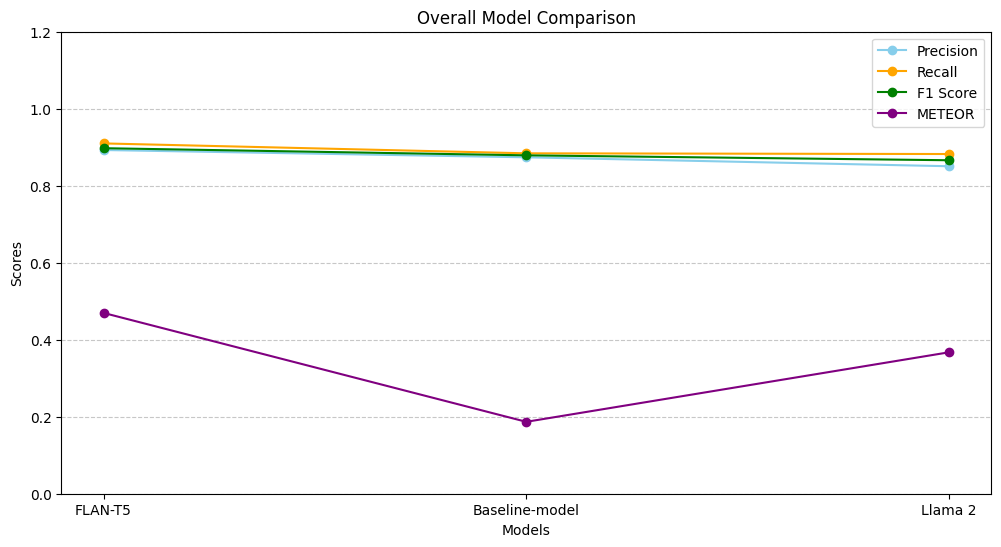

In [170]:
# Import necessary libraries for data handling, plotting, and numerical operations.
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Define a function to load evaluation scores from a JSON file.
def load_scores(file_name):
    file_path = os.path.join(file_name)
    with open(file_path, "r") as f:
        return json.load(f)

# Load the evaluation scores for each model from their respective JSON files.
flan_t5_scores = load_scores("/content/flan-t5-small-evaluation.json")
t5_base_scores = load_scores("/content/baseline_evaluation_results.json")
llama2_scores = load_scores("/content/Llama2_evaluation_results.json") # Load Llama 2 scores

# Define the names of the models for visualization purposes.
models = ["FLAN-T5", "Baseline-model", "Llama 2"]

# Define a helper function to compute the mean of a score. Handles both scalar and list scores.
def mean_score(score):
    return np.mean(score) if isinstance(score, list) else score

# Prepare data for BERTScore comparison.
# Extract and compute the average precision, recall, and F1 scores for each model.
bertscore_data = {
    "Model": models,
    "Precision": [
        mean_score(flan_t5_scores["BERTScore"]["precision"]),
        mean_score(t5_base_scores["BERTScore"]["precision"]),
        mean_score(llama2_scores["BERTScore"]["precision"])
    ],
    "Recall": [
        mean_score(flan_t5_scores["BERTScore"]["recall"]),
        mean_score(t5_base_scores["BERTScore"]["recall"]),
        mean_score(llama2_scores["BERTScore"]["recall"])
    ],
    "F1 Score": [
        mean_score(flan_t5_scores["BERTScore"]["f1"]),
        mean_score(t5_base_scores["BERTScore"]["f1"]),
        mean_score(llama2_scores["BERTScore"]["f1"])
    ]
}

# Prepare data for METEOR comparison.
# Extract the METEOR score for each model. Handle cases where METEOR might be a dictionary or scalar.
meteor_data = [
    flan_t5_scores["METEOR"]["score"] if isinstance(flan_t5_scores.get("METEOR"), dict) else flan_t5_scores.get("METEOR"),
    t5_base_scores["METEOR"]["score"] if isinstance(t5_base_scores.get("METEOR"), dict) else t5_base_scores.get("METEOR"),
    llama2_scores["METEOR"]["score"] if isinstance(llama2_scores.get("METEOR"), dict) else llama2_scores.get("METEOR")
]


# Convert BERTScore data to a Pandas DataFrame for easier plotting with Seaborn (though direct plotting is also used).
bertscore_df = pd.DataFrame({
    "Model": models * 3,
    "Metric": ["Precision", "Recall", "F1 Score"] * len(models),
    "Score": (
        bertscore_data["Precision"] +
        bertscore_data["Recall"] +
        bertscore_data["F1 Score"]
    )
})

# Plot BERTScore Comparison as a Bar Chart.
plt.figure(figsize=(8, 4))
bar_width = 0.2
index = np.arange(len(models))

plt.bar(index, bertscore_data["Precision"], bar_width, label='Precision', color='skyblue')
plt.bar(index + bar_width, bertscore_data["Recall"], bar_width, label='Recall', color='orange')
plt.bar(index + 2 * bar_width, bertscore_data["F1 Score"], bar_width, label='F1 Score', color='green')

plt.xlabel('Models')
plt.ylabel('BERTScore')
plt.title('BERTScore Comparison')
plt.xticks(index + bar_width, models)
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for scores.
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot METEOR Comparison as a Bar Chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=meteor_data, palette="magma") # Use Seaborn for a visually appealing bar plot.
plt.title("METEOR Comparison")
plt.xlabel("Models")
plt.ylabel("METEOR Score")
plt.ylim(0, 1) # Set y-axis limit from 0 to 1.
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a Line Chart for Overall Comparison of all metrics.
plt.figure(figsize=(12, 6))
plt.plot(models, bertscore_data["Precision"], marker='o', linestyle='-', label='Precision', color='skyblue')
plt.plot(models, bertscore_data["Recall"], marker='o', linestyle='-', label='Recall', color='orange')
plt.plot(models, bertscore_data["F1 Score"], marker='o', linestyle='-', label='F1 Score', color='green')
plt.plot(models, meteor_data, marker='o', linestyle='-', label='METEOR', color='purple')

plt.title("Overall Model Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.ylim(0, 1.2) # Set y-axis limit.
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

**Adaptive Difficulty (Prompt Engineering)**

In [171]:
# Clear CUDA memory and reset memory statistics. This is useful to free up GPU memory
# before loading a model or running computationally intensive tasks.
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_accumulated_memory_stats()

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [172]:
# Load the T5 Model and Tokenizer for adaptive difficulty question generation.
# Using a smaller model ('google/flan-t5-small') for efficiency.
model_checkpoint = "google/flan-t5-small"
tokenizer = T5TokenizerFast.from_pretrained(model_checkpoint)
# Load the model and move it to the GPU if available.
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint).to("cuda")
# Set the model to evaluation mode. This disables dropout and other training-specific layers.
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [173]:
# Define prompt templates for generating questions of different difficulty levels.
# These templates guide the model on the type of question to generate based on the desired difficulty.
prompt_templates = {
    # Easy questions focus on simple facts or details from the context.
    "easy": "Generate a simple, factual question about a specific detail in: {}",
    # Medium questions require some analysis or reasoning about strategic impact or relationships.
    "medium": "Generate an analytical question requiring reasoning about the strategic impact of: {}",
    # Hard questions encourage deeper thought, comparison, or consideration of complex implications like ethics or history.
    "hard": "Generate a thought-provoking question comparing historical contexts or ethical implications of: {}, ensuring it avoids repetition and uses specific details from the context"
}

In [174]:
# Define the function to generate questions with adaptive difficulty.
def generate_difficulty_question(context, difficulty):
    # Select the appropriate prompt template based on the requested difficulty.
    prompt = prompt_templates[difficulty].format(context)

    # Tokenize the input prompt and prepare it for the model.
    inputs = tokenizer(
        prompt,
        return_tensors="pt",  # Return PyTorch tensors.
        padding="max_length", # Pad to the maximum length specified.
        truncation=True,      # Truncate if the input is longer than max_length.
        max_length=128        # Maximum length of the input sequence.
    ).to("cuda") # Move the input tensors to the GPU.

    # Generate the output using the model.
    with torch.no_grad(): # Disable gradient calculation during inference.
        outputs = model.generate(
            inputs['input_ids'],      # Input token IDs.
            max_length=80,          # Maximum length of the generated question.
            num_beams=5,            # Use beam search with 5 beams for better quality.
            no_repeat_ngram_size=3, # Prevent repeating n-grams of size 3.
            early_stopping=True     # Stop generation early if all beams have finished.
        )

    # Decode the generated token IDs back to text and clean up the output.
    question = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Remove extra whitespace and leading/trailing spaces.
    question = re.sub(r'\s+', ' ', question).strip()

    # Post-processing to ensure the generated text is a valid question.
    # Capitalize the first letter if it's not already capitalized.
    if not question[0].isupper():
        question = question.capitalize()
    # Add a question mark at the end if it's missing.
    if not question.endswith("?"):
        question += "?"

    # Additional checks for question validity and uniqueness.
    # If the question is too short or is identical to the context, generate a default question.
    if len(question.split()) < 5 or question in context:
        question = "What is the main idea of the context?"

    # Clear GPU memory to free up resources.
    del inputs, outputs
    torch.cuda.empty_cache()

    return question

In [175]:
# Define the main function for adaptive difficulty question generation.
def adaptive_difficulty(context, reference):
    # Define the difficulty levels to cycle through.
    difficulty_levels = ["easy", "medium", "hard"]
    generated_questions = []
    seen_questions = set() # Use a set to keep track of generated questions for uniqueness.

    # Iterate through each difficulty level.
    for difficulty in difficulty_levels:
        print(f"\nGenerating {difficulty} question...")
        # Generate a question for the current difficulty level.
        question = generate_difficulty_question(context, difficulty)
        # Ensure the generated question is unique and of sufficient length.
        if question in seen_questions or len(question.split()) < 5:
            # If the question is not unique or too short, generate a fallback question.
            question = f"What is a key {difficulty} aspect of {context.split('.')[0]}?"
            # If the fallback question is also a duplicate, add more detail to make it unique.
            if question in seen_questions:
                question += f" related to {difficulty} challenges?"
        # Add the generated question to the set of seen questions.
        seen_questions.add(question)
        print(f"Difficulty: {difficulty}")
        print(f"Generated Question: {question}\n")
        # Append the generated question to the list of generated questions.
        generated_questions.append(question)

    # Print the final list of generated questions.
    print("\nFinal Generated Questions:")
    for idx, q in enumerate(generated_questions, 1):
        print(f"{idx}. {q}")

    return generated_questions

In [176]:
# Define an example context and a list of human-written reference questions.
context = "Artificial intelligence is revolutionizing various industries, from healthcare to finance. It enhances productivity, automates tasks, and provides insights through data analysis."
reference = [
    "What impact does AI have on the job market?",
    "How can AI be ethically implemented in healthcare?",
    "What are the risks and benefits of using AI for financial decision-making?"
]


# Run the adaptive_difficulty function with the example context and reference.
adaptive_difficulty(context, reference)


Generating easy question...
Difficulty: easy
Generated Question: What is the name of the technology that is revolutionizing various industries?


Generating medium question...
Difficulty: medium
Generated Question: What is the strategic impact of Artificial Intelligence?


Generating hard question...
Difficulty: hard
Generated Question: Which of the following is an example of artificial intelligence?


Final Generated Questions:
1. What is the name of the technology that is revolutionizing various industries?
2. What is the strategic impact of Artificial Intelligence?
3. Which of the following is an example of artificial intelligence?


['What is the name of the technology that is revolutionizing various industries?',
 'What is the strategic impact of Artificial Intelligence?',
 'Which of the following is an example of artificial intelligence?']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Question Evaluation Results:


,Generated Question,BERT Precision,BERT Recall,BERT F1,METEOR,Token F1,Relevance
0,What is the name of the technology that is rev...,0.507318,0.708789,0.606463,0.489474,0.500000,0.855783
1,What is the strategic impact of Artificial Int...,0.707122,0.655811,0.681687,0.459259,0.400000,0.891842
2,Which of the following is an example of artifi...,0.573455,0.723427,0.647717,0.751996,0.705882,0.862931


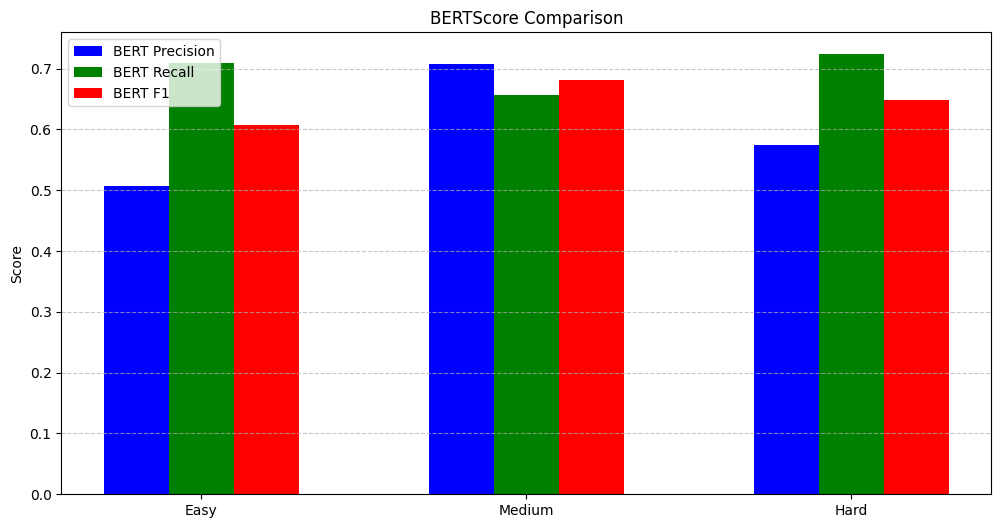

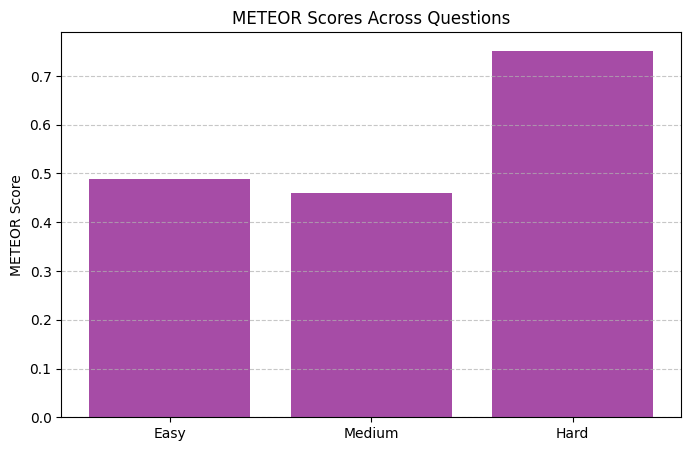

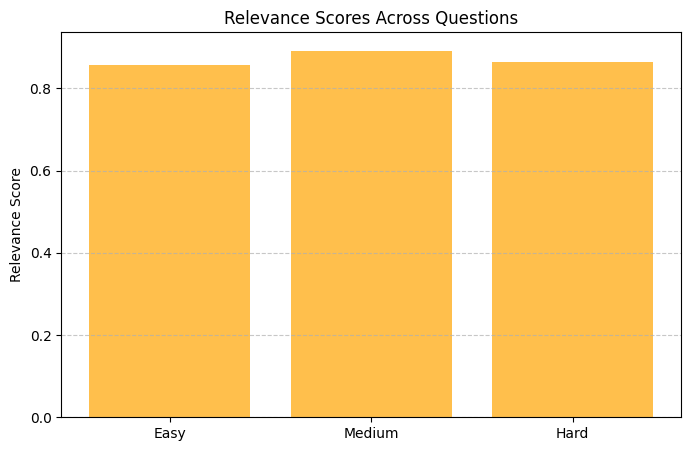

In [178]:
nltk.download('punkt')  # For tokenization
nltk.download('wordnet')  # Needed for METEOR
nltk.download('omw-1.4')

# ==========================
# 2. Reference and Generated Questions
# ==========================
reference_questions = [
    "What technology is transforming multiple industries?",
    "How does Artificial Intelligence impact strategic decision-making?",
    "Which option represents an example of Artificial Intelligence?"
]

generated_questions = [
    "What is the name of the technology that is revolutionizing various industries?",
    "What is the strategic impact of Artificial Intelligence?",
    "Which of the following is an example of artificial intelligence?"
]

# ==========================
# 3. Compute BERTScore (Force CPU to Avoid Out of Memory)
# ==========================
torch.cuda.empty_cache()  # Free GPU memory

bert_P, bert_R, bert_F1 = bert_score_func(
    generated_questions, reference_questions,
    model_type="roberta-base",  # Changed model_type to a more compatible one
    lang="en",
    device="cpu",  # Force CPU execution
    batch_size=1,  # Reduce memory usage
    rescale_with_baseline=True
)

# ==========================
# 4. Compute METEOR Scores (Tokenized Input)
# ==========================
tokenized_reference_questions = [word_tokenize(ref) for ref in reference_questions]
tokenized_generated_questions = [word_tokenize(gen) for gen in generated_questions]

meteor_scores = [
    meteor_score([ref], gen)
    for ref, gen in zip(tokenized_reference_questions, tokenized_generated_questions)
]

# ==========================
# 5. Compute Token-Level F1 Score
# ==========================
def compute_token_f1(reference, candidate):
    ref_tokens = set(reference.lower().split())
    gen_tokens = set(candidate.lower().split())

    tp = len(ref_tokens & gen_tokens)  # True Positives
    fp = len(gen_tokens - ref_tokens)  # False Positives
    fn = len(ref_tokens - gen_tokens)  # False Negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1

token_f1_scores = [compute_token_f1(ref, gen) for ref, gen in zip(reference_questions, generated_questions)]

# ==========================
# 6. Compute Relevance Score (Cosine Similarity - Force CPU)
# ==========================
# Load the model on CPU to prevent Out of Memory errors
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

# Compute sentence embeddings without converting to tensors
ref_embeddings = model.encode(reference_questions, convert_to_tensor=False)
gen_embeddings = model.encode(generated_questions, convert_to_tensor=False)

# Compute cosine similarity for relevance
relevance_scores = [
    float(util.pytorch_cos_sim(ref_embeddings[i], gen_embeddings[i])[0][0])
    for i in range(len(reference_questions))
]

# ==========================
# 7. Store and Display Results
# ==========================
results_df = pd.DataFrame({
    "Generated Question": generated_questions,
    "BERT Precision": bert_P.numpy(),
    "BERT Recall": bert_R.numpy(),
    "BERT F1": bert_F1.numpy(),
    "METEOR": meteor_scores,
    "Token F1": token_f1_scores,
    "Relevance": relevance_scores
})

# Display DataFrame in Jupyter Notebook / Colab
from IPython.display import display

print("📊 Question Evaluation Results:")
display(results_df)

# ==========================
# 8. Plot the Scores
# ==========================
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(generated_questions))

plt.bar(index, bert_P.numpy(), bar_width, label='BERT Precision', color='blue')
plt.bar(index + bar_width, bert_R.numpy(), bar_width, label='BERT Recall', color='green')
plt.bar(index + 2 * bar_width, bert_F1.numpy(), bar_width, label='BERT F1', color='red')

plt.xticks(index + bar_width, ["Easy", "Medium", "Hard"])
plt.ylabel("Score")
plt.title("BERTScore Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot METEOR Scores
plt.figure(figsize=(8, 5))
plt.bar(["Easy", "Medium", "Hard"], meteor_scores, color='purple', alpha=0.7)
plt.ylabel("METEOR Score")
plt.title("METEOR Scores Across Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Relevance Scores
plt.figure(figsize=(8, 5))
plt.bar(["Easy", "Medium", "Hard"], relevance_scores, color='orange', alpha=0.7)
plt.ylabel("Relevance Score")
plt.title("Relevance Scores Across Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**SHAP values for interpretation**

In [1]:
# Install dependencies (Uncomment if running in a fresh environment)
# !pip install transformers torch

import torch
from transformers import AutoModelForSequenceClassification, DistilBertTokenizerFast # Import DistilBertTokenizerFast

# Device Setup
device = "cpu"  # Using CPU to avoid GPU memory issues
print(f"Using device: {device}")

# ** Using a Fine-Tuned Sentiment Analysis Model **
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Fine-tuned for sentiment analysis

# Load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # Use DistilBertTokenizerFast
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to CPU
model.to(device)
model.eval()

print("✅ Model loaded successfully!")

Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✅ Model loaded successfully!


In [ ]:
context = "Artificial intelligence is transforming industries with automation and data-driven insights. However, ethical considerations like bias, privacy, and accountability are crucial."
background_texts = [
    "AI is making healthcare more efficient but raises ethical concerns about patient privacy.",
    "Automation is improving productivity but may lead to job losses.",
    "Ethical AI is necessary to ensure fairness and accountability in decision-making."
]


In [ ]:

# Custom Prediction Function for SHAP
def predict(texts):
    # Convert NumPy array to list of strings if needed
    if isinstance(texts, np.ndarray):
        texts = [tokenizer.decode(text, skip_special_tokens=True) for text in texts]

    # Tokenize Inputs
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    # Make Predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get Probabilities
    logits = outputs.logits.cpu().numpy()
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    return probabilities

# Tokenize Background Texts and Convert to NumPy Array
background_inputs = tokenizer(
    background_texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)
background_texts_np = background_inputs['input_ids'].cpu().numpy()

# Use SHAP KernelExplainer with More Samples
explainer = shap.KernelExplainer(predict, background_texts_np)
input_data = np.expand_dims(background_texts_np[0], axis=0)
shap_values = explainer.shap_values(input_data, nsamples=50)  # Increased nsamples for better accuracy

# Tokenization for SHAP Visualization
tokens = tokenizer.convert_ids_to_tokens(background_inputs['input_ids'][0])

# Debugging: Check SHAP Values Shape
print("SHAP Values Shape:", np.array(shap_values).shape)

# Check the Number of Classes in SHAP Values
num_classes = len(shap_values)
print("Number of Classes:", num_classes)

# ** Aggregate SHAP Values Across Classes **
if num_classes > 1:
    # Average SHAP values across both classes
    shap_values_class = np.mean(shap_values, axis=0).flatten()
else:
    # Use the only available class
    shap_values_class = shap_values[0].flatten()

# ** Ensure Matching Lengths **
shap_values_class = shap_values_class[:len(tokens)]

# ** Visualization: SHAP Token Importance as Horizontal Bar Plot **
plt.figure(figsize=(12, 6))
plt.barh(tokens, shap_values_class, color='purple')
plt.xlabel("SHAP Value")
plt.ylabel("Token")
plt.title("SHAP Token Importance (Aggregated Across Classes)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
